# Variational Autoencoder in Pytorch

**Author:** Jhosimar George Arias Figueroa

This notebook contains a **pytorch** implementation of a Variational Autoencoder (VAE). The model is based on Kingma et al. (https://arxiv.org/abs/1312.6114).

## Install Pytorch

In [1]:
!pip install torch

## Import Libraries

In [0]:
import random
import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

## Hyperparameters

In [0]:
CUDA = 1          # if we run the code on GPU
SEED = 1          # random seed
BATCH_SIZE = 64   # batch size of training and test
EPOCHS = 10       # number of epochs for training
LATENT_DIM = 128  # size of the latent gaussian

Set random seed

In [0]:
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if CUDA:
  torch.cuda.manual_seed(SEED)

## MNIST Dataset

The MNIST dataset consists of 70000 handwritten digits of 28×28 pixel size and 10 classes, of which 60000 images are considered for training and 10000 images for testing. This dataset can be obtained directly from the [dataset package](https://pytorch.org/docs/stable/torchvision/datasets.html/).

In [0]:
# DataLoader instances will load tensors directly into GPU memory
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}

# Download or load downloaded MNIST dataset
# shuffle data at every epoch
train_dataset = datasets.MNIST('./mnist', train=True, download=True, transform=transforms.ToTensor())
#train_loader = torch.utils.data.DataLoader(datasets.MNIST('./mnist', train=True, download=True, transform=transforms.ToTensor()),
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

# Same for test data
test_dataset = datasets.MNIST('./mnist', train=False, transform=transforms.ToTensor())
#test_loader = torch.utils.data.DataLoader(datasets.MNIST('./mnist', train=False, transform=transforms.ToTensor()),
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

Let's visualize what the training data looks like:

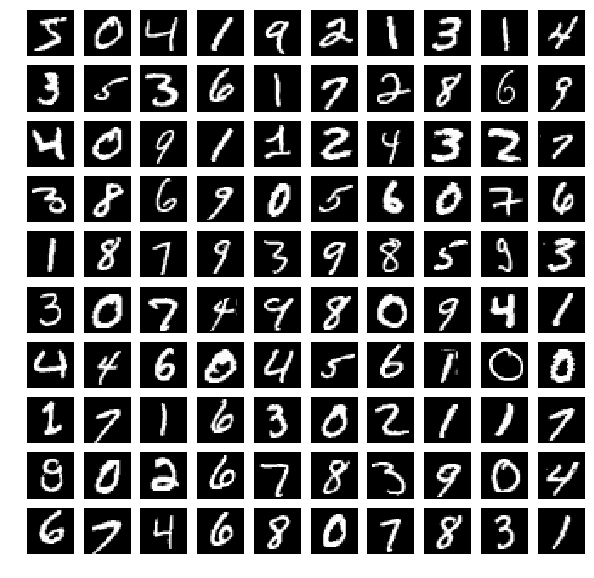

In [6]:
visualize_data = train_dataset.data[0:100].numpy()
plt.figure(figsize=[10,10])
for i in range(0,100):
  plt.subplot(10,10,i+1)
  plt.imshow(np.reshape(visualize_data[i], (28,28)), interpolation='none',cmap=plt.get_cmap('gray'))
  plt.axis('off')

## VAE Model

Let's define the neural network of our Variational Autoencoder

In [0]:
class VAE(nn.Module):
  
  def __init__(self):
    super(VAE, self).__init__()
    self.fc1 = nn.Linear(784, 500)
    self.fc2 = nn.Linear(500, 500)
    self.mu = nn.Linear(500, LATENT_DIM)
    self.logVar = nn.Linear(500, LATENT_DIM)
    self.fc4 = nn.Linear(LATENT_DIM, 500)
    self.fc5 = nn.Linear(500, 500)
    self.fc6 = nn.Linear(500, 784)
  
  def encoder(self, x):
    h1 = F.relu(self.fc1(x.view(-1, 784)))
    h2 = F.relu(self.fc2(h1))  
    mu = self.mu(h2)
    logVar = self.logVar(h2)
    return mu, logVar
  
  def reparameterize(self, mu, logVar):
    std = torch.exp(0.5 * logVar)
    noise = torch.randn_like(std)
    z = mu + noise * std
    return z
  
  def decoder(self, z):
    h4 = F.relu(self.fc4(z))
    h5 = F.relu(self.fc5(h4))
    out = F.sigmoid(self.fc6(h5))
    return out
  
  def forward(self, x):
    mu, logVar = self.encoder(x)
    z = self.reparameterize(mu, logVar)
    out = self.decoder(z)
    return out, mu, logVar

###Network initialization

In [0]:
model = VAE()

if CUDA:
  model.cuda()

### Network optimizer

In [0]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Loss Function

In [0]:
def loss_function(x, x_recon, mu, logVar):
  # Binary Cross Entropy
  BCE = F.binary_cross_entropy(x_recon, x.view(-1, 784), reduction='sum')
  
  # see Appendix B from VAE paper:
  # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
  # https://arxiv.org/abs/1312.6114
  # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
  KL = -0.5 * torch.sum(1 + logVar - torch.exp(logVar) - torch.pow(mu, 2) ) 
  
  return BCE + KL

### Train and Test Functions

In [0]:
def train(train_loader):
  model.train()
  train_loss = 0.0
  
  for batch_index, (data, _) in enumerate(train_loader):
    if CUDA:
      data = data.cuda()
    data_recon, mu, logVar = model.forward(data)
    optimizer.zero_grad()
    loss = loss_function(data, data_recon, mu, logVar)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  train_loss /= (1.0 * len(train_loader.dataset))
  
  return train_loss

In [0]:
def test(test_loader):
  model.eval()
  test_loss = 0.0
  
  with torch.no_grad():
    for batch_index, (data, _) in enumerate(test_loader):
      if CUDA:
        data = data.cuda()
      data_recon, mu, logVar = model.forward(data)
      loss = loss_function(data, data_recon, mu, logVar)
      test_loss += loss
    
  test_loss /= (1.0 * len(test_loader.dataset))
  return test_loss

## Train Model

In [13]:
for epoch in range(1, EPOCHS + 1):
  train_loss = train(train_loader)
  test_loss = test(test_loader)
  print('Epoch (%d/%d) - Train_Loss: %.3lf, Test_Loss: %.3lf' % (epoch, EPOCHS, train_loss, test_loss))

/usr/local/lib/python2.7/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch (1/10) - Train_Loss: 166.800, Test_Loss: 136.359
Epoch (2/10) - Train_Loss: 126.363, Test_Loss: 120.106
Epoch (3/10) - Train_Loss: 118.004, Test_Loss: 114.992
Epoch (4/10) - Train_Loss: 113.729, Test_Loss: 111.296
Epoch (5/10) - Train_Loss: 110.672, Test_Loss: 109.139
Epoch (6/10) - Train_Loss: 108.858, Test_Loss: 108.334
Epoch (7/10) - Train_Loss: 107.677, Test_Loss: 107.480
Epoch (8/10) - Train_Loss: 106.445, Test_Loss: 105.867
Epoch (9/10) - Train_Loss: 105.412, Test_Loss: 104.900
Epoch (10/10) - Train_Loss: 104.512, Test_Loss: 104.200


## Image Reconstruction

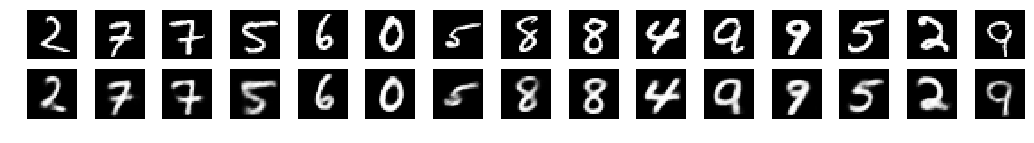

In [14]:
def reconstruction(test_dataset, SAMPLE_SIZE=15):
  indices = np.random.randint(0, len(test_dataset), size=SAMPLE_SIZE)
  test_random_loader = torch.utils.data.DataLoader(test_dataset, batch_size=SAMPLE_SIZE, sampler=SubsetRandomSampler(indices))
  it = iter(test_random_loader)
  test_batch_data, _ = it.next()
  original = test_batch_data.data.numpy()
  if CUDA:
    test_batch_data = test_batch_data.cuda()
  reconstructed, _, _ = model.forward(test_batch_data)
  return original, reconstructed.data.cpu().numpy()

def display_reconstructed(original, reconstructed, n=10):
  plt.figure(figsize=[18,2])
  for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(original[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    
    if reconstructed is not None:
      plt.subplot(2, n, i + n + 1)
      plt.imshow(reconstructed[i].reshape(28, 28))
      plt.gray()
      plt.axis('off')
  plt.show()

original, reconstructed = reconstruction(test_dataset, 15)
display_reconstructed(original, reconstructed, 15)

## Image Generation

In [0]:
def generation(num_elem):
  z = torch.randn(num_elem, LATENT_DIM)
  if CUDA:
    z = z.cuda()
  out = model.decoder(z).cpu()
  out = out.view(num_elem, 28, 28).data.numpy()
  return out

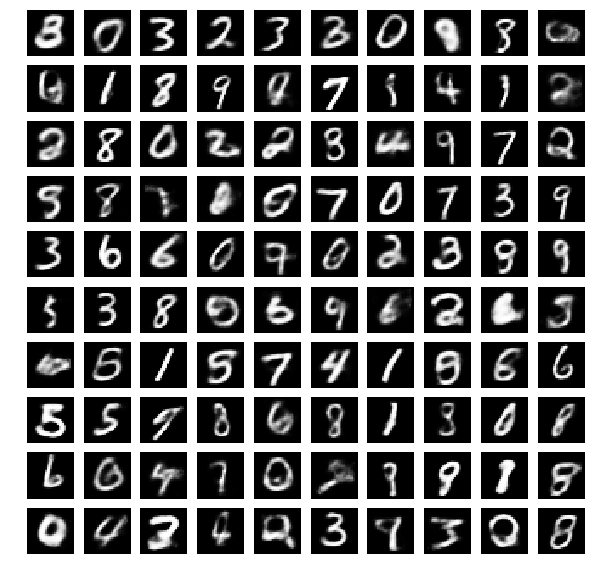

In [16]:
generated = generation(100)

plt.figure(figsize=[10,10])
for i in range(0, 100):
  plt.subplot(10,10,i+1)
  plt.imshow(generated[i], interpolation='none',cmap=plt.get_cmap('gray'))
  plt.axis('off')
plt.show()